# Laboratory Ten

In [3]:
# Some standard code imports
import matplotlib.pyplot as plt 
import matplotlib.axes as axes
import numpy as np

# For drawing graphs
import networkx as nx

# Qiskit imports
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.optimization import QuadraticProgram
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.converters import LinearEqualityToPenalty
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.aqua.algorithms import VQE
from qiskit.circuit.library import RealAmplitudes

# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon = True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

#### Procedure
The first thing that you need to do is create the graph data structure. The process for doing this is shown on slide 11 of the quantum optimization lecture.

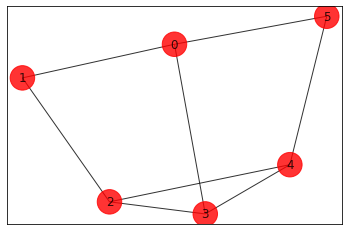

In [4]:
#Create graph
G = nx.Graph()

#Add 5 modes
n = 6
G.add_nodes_from(range(n))

#Add edges: tuple is (i,j,weight) where (i,j) is the edge
edges = [(0, 1, 1.0), (0, 5, 1.0), (4, 5, 1.0),(0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

#Plot graph
plot_result(G, [0]*n)

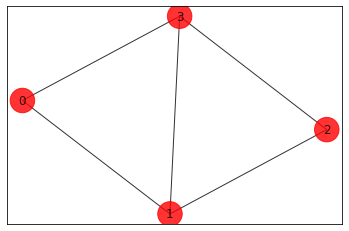

In [8]:
#Create graph
G = nx.Graph()

#Add 5 modes
n = 4
G.add_nodes_from(range(n))

#Add edges: tuple is (i,j,weight) where (i,j) is the edge
edges = [(0, 1, 1.0), (1, 3, 1.0),(0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(edges)

#Plot graph
plot_result(G, [0]*n)

Once you have the graph constructed you need to build the DOcplex description of the optimization. Slide 15 shows the code for doing this. Remember, we are doing a minimization and not a maximization.

In [9]:
# Import a model from DOcplex
from docplex.mp.model import Model

# Name the model
ndl = Model('MinCut')

# Add a binary variable to the model for each node in the graph
x = ndl.binary_var_list('x{}'.format(i) for i in range(n))

# Define the objective function
objective = ndl.sum([w * (x[i] + x[j] - 2*x[i]*x[j]) for (i, j, w) in edges])

# Add an equality constraint
b = 2
ndl.add_constraint(ndl.sum(x) == b)

# And let's maximize it!
ndl.minimize(objective)

# Let's print the model
ndl.prettyprint()

// This file has been generated by DOcplex
// model name is: MinCut
// var contrainer section
dvar bool x[4];

minimize
 2 x0 + 3 x1 + 2 x2 + 3 x3 [ - 2 x0*x1 - 2 x0*x3 - 2 x1*x2 - 2 x1*x3 - 2 x2*x3
 ];
 
subject to {
 x0 + x1 + x2 + x3 == 2;

}


Next convert the DOcplex description into a quadratic problem as shown on slide 17. At each step you should be checking your results. They will be different from the results in the lecture slides, due to the different problem, but they should look similar.

In [10]:
# Instantiate an empty QuadraticProgram object
qp = QuadraticProgram()

# Put the model inside it
qp.from_docplex(ndl)

print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MinCut

Minimize
 obj: 2 x0 + 3 x1 + 2 x2 + 3 x3 + [ - 4 x0*x1 - 4 x0*x3 - 4 x1*x2 - 4 x1*x3
      - 4 x2*x3 ]/2
Subject To
 c0: x0 + x1 + x2 + x3 = 2

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1

Binaries
 x0 x1 x2 x3
End



Now that we have a quadratic problem, we can use a classical solver to determine the correct answer to our optimization problem. The process for doing this is shown on slide 20.

optimal function value: 6.0
optimal value: [1. 0. 1. 0. 0. 0.]
status: SUCCESS


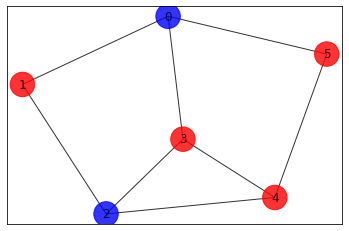

In [67]:
solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = solver.solve(qp)
print(result)
plot_result(G, result.x)

With the answer in hand the next step is to remove the constraint from the quadratic problem to produce a QUBO. Slide 23 shows how this can be done.

In [68]:
eq_converter = LinearEqualityToPenalty()
qp_eq = eq_converter.convert(qp)
print(qp_eq.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Maximize
 obj: 135 x0 + 134 x1 + 135 x2 + 135 x3 + 135 x4 + 134 x5 + [ - 66 x0^2
      - 136 x0*x1 - 132 x0*x2 - 136 x0*x3 - 132 x0*x4 - 136 x0*x5 - 66 x1^2
      - 136 x1*x2 - 132 x1*x3 - 132 x1*x4 - 132 x1*x5 - 66 x2^2 - 136 x2*x3
      - 136 x2*x4 - 132 x2*x5 - 66 x3^2 - 136 x3*x4 - 132 x3*x5 - 66 x4^2
      - 136 x4*x5 - 66 x5^2 ]/2 -132
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



Now we can convert our optimization problem into an Ising model. The steps for doing this are shown on slide 32. Remember, that the offset value is important.

In [69]:
H, offset = qp_eq.to_ising()
print('offset =', offset)
print('H =', H)

offset = 78.5
H = SummedOp([
  -33.0 * IIIIIZ,
  -33.0 * IIIIZI,
  -33.0 * ZIIIII,
  -33.0 * IZIIII,
  -33.0 * IIZIII,
  -33.0 * IIIZII,
  17.0 * IIIIZZ,
  16.5 * IIIZIZ,
  17.0 * IIIZZI,
  17.0 * IIZIIZ,
  16.5 * IIZIZI,
  17.0 * IIZZII,
  16.5 * IZIIIZ,
  16.5 * IZIIZI,
  17.0 * IZIZII,
  17.0 * IZZIII,
  17.0 * ZIIIIZ,
  16.5 * ZIIIZI,
  16.5 * ZIIZII,
  16.5 * ZIZIII,
  17.0 * ZZIIII
])


Slide 34 shows how we can quickly verify the Ising model. You need to make one important change to this code. On the call to plt.xticks() you need to change the format from {0:05b} to {0:06b} since we now have 6 vertices in the graph.

Minimum energy for Hamiltonian: -84.5


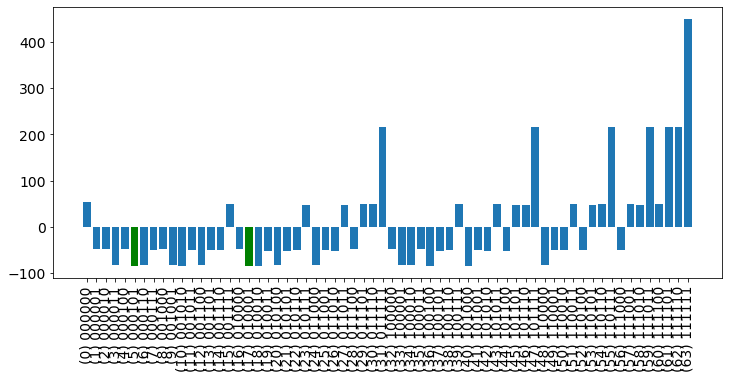

In [70]:
H_matrix = np.real(H.to_matrix())

#Get the set of basis states which have the lowest energy
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12,5))

print('Minimum energy for Hamiltonian: {0}' .format(min(H_matrix.diagonal())))
# Plot the expectation value of the energy of the different basis states,
# and color those basis states which would have the lowest energy
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:06b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Finally create the ansatz as shown on slide 37 and call VQE as shown on slide 38. Note, when constructing the ansatz you will need to change the first parameter to RealAmplitudes() from 5 to 7. This will give you the optimal value. 

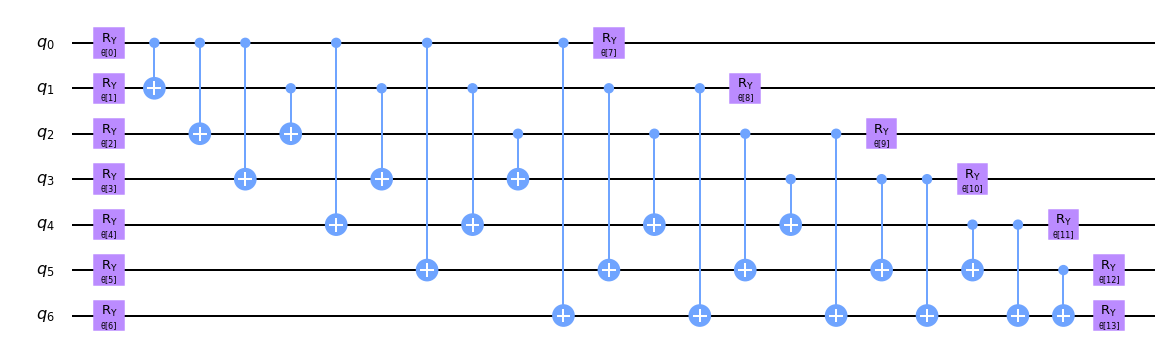

In [71]:
qc = RealAmplitudes(7, reps = 1)
qc.draw(output='mpl')

In [72]:
# slide 38
vqe = VQE(H, qc, quantum_instance=Aer.get_backend('statevector_simulator'))
result = vqe.run()
print('Estimated optimal value:', np.round(result.eigenvalue, decimals=4))

Estimated optimal value: (-84.5+0j)


Next plot the results as shown on slide 39. Remember, to change the format in the call to plt.xticks(). You are now done.

Probability of observing an optimal bitstring: 0.9999999911231596


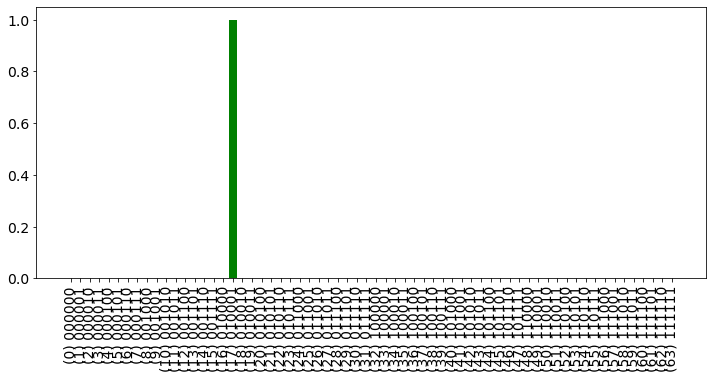

In [73]:
probabilities = np.abs(result.eigenstate)**2

opt_probs = probabilities[opt_indices]
print('Probability of observing an optimal bitstring: {0}'.format(np.sum(opt_probs)))
# Plot probabilities
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, opt_probs, color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:06b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()